# Experiment 1: Failure Mode Analysis

This notebook analyzes the modes of failure for different evaluation categories.

**Objective:** Understand why agents and MCPs fail on different types of tasks, and identify common failure patterns.

**Key questions:**
- What causes failures in each evaluation category?
- Are there common failure modes across agents/MCPs?
- Why do Publication status tasks fail at all?

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from collections import Counter
import re

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

## Load Results from All Agents

In [2]:
# Load all agent results
result_files = {
    "claude": "../results/compare_agents/claude_20251106.yaml",
    "gemini": "../results/compare_agents/gemini_20251106.yaml",
    "goose": "../results/compare_agents/goose_20251106.yaml",
}

agent_results = {}
for agent, filepath in result_files.items():
    with open(filepath, "r") as f:
        agent_results[agent] = yaml.safe_load(f)
    print(f"✓ Loaded {agent}: {len(agent_results[agent]['results'])} results")

# Convert to DataFrames
dfs = {}
for agent, results in agent_results.items():
    df = pd.DataFrame(results["results"])
    df = df.explode("servers")
    df["MCP"] = df["servers"]
    df["agent"] = agent
    dfs[agent] = df

# Combine all results
df_all = pd.concat(dfs.values(), ignore_index=True)

print(f"\nCombined: {len(df_all)} total results")
print(f"Pass rate: {df_all['passed'].mean()*100:.1f}%")

✓ Loaded claude: 100 results


✓ Loaded gemini: 100 results


✓ Loaded goose: 100 results

Combined: 300 total results
Pass rate: 23.0%


## Overall Failure Statistics by Category

In [3]:
# Failure rates by category
category_stats = df_all.groupby('case_group').agg({
    'passed': ['count', 'sum', 'mean'],
    'score': 'mean'
}).round(3)

category_stats.columns = ['total_cases', 'passed_cases', 'pass_rate', 'mean_score']
category_stats['failed_cases'] = category_stats['total_cases'] - category_stats['passed_cases']
category_stats = category_stats.sort_values('pass_rate')

print("Failure Statistics by Evaluation Category:")
print("="*80)
print(category_stats[['total_cases', 'failed_cases', 'pass_rate', 'mean_score']])

Failure Statistics by Evaluation Category:
                                           total_cases  failed_cases  \
case_group                                                             
Text extraction                                    132           117   
Summarization                                       24            21   
Supplementary material                              36            28   
Table / Figure / Figure Legend extraction           48            34   
Metadata                                            48            26   
Publication status                                  12             5   

                                           pass_rate  mean_score  
case_group                                                        
Text extraction                                0.114       0.265  
Summarization                                  0.125       0.276  
Supplementary material                         0.222       0.351  
Table / Figure / Figure Legend extraction    

## Publication Status Failures - Detailed Analysis

Publication status should be straightforward - why are there failures?

In [4]:
# Filter for Publication status cases
pub_status = df_all[df_all['case_group'] == 'Publication status'].copy()
pub_status_failures = pub_status[~pub_status['passed']].copy()

print(f"Publication status: {len(pub_status_failures)} failures out of {len(pub_status)} cases")
print(f"Failure rate: {len(pub_status_failures)/len(pub_status)*100:.1f}%")
print("\nFailure breakdown by agent:")
print(pub_status_failures.groupby('agent').size())
print("\nFailure breakdown by MCP:")
print(pub_status_failures.groupby('MCP').size())

Publication status: 5 failures out of 12 cases
Failure rate: 41.7%

Failure breakdown by agent:
agent
claude    1
gemini    1
goose     3
dtype: int64

Failure breakdown by MCP:
MCP
artl             1
biomcp           1
pubmed-mcp       2
simple-pubmed    1
dtype: int64


In [5]:
# Examine individual Publication status failures
print("Publication Status Failure Examples:")
print("="*80)

for i, (idx, row) in enumerate(pub_status_failures.head(5).iterrows(), 1):
    print(f"\n{i}. {row['case_name']}")
    print(f"   Agent: {row['agent']}, MCP: {row['MCP']}, Score: {row['score']:.3f}")
    print(f"   Reason: {row['reason'][:300]}...")
    print(f"   Actual output: {row['actual_output'][:300]}...")
    print("-"*80)

Publication Status Failure Examples:

1. PMC4831113_Retraction
   Agent: claude, MCP: artl, Score: 0.720
   Reason: The actual output does not contradict the expected output and correctly states that PMC4831113 is retracted, aligning with the expected answer. However, it includes significantly more detail than required, which is not penalized by the evaluation steps, but omission of detail is to be penalized, not...
   Actual output: ## Answer

**Yes, PMC4831113 is retracted.**

## Details

**Original Article:**
- **PMID**: 27081435
- **PMC**: PMC4831113
- **Title**: "High-quality draft genome sequence and description of Haemophilus massiliensis sp. nov."
- **Journal**: Standards in Genomic Sciences (2016) 11:31
- **DOI**: 10.11...
--------------------------------------------------------------------------------

2. PMC4831113_Retraction
   Agent: gemini, MCP: pubmed-mcp, Score: 0.021
   Reason: The actual output directly contradicts the expected output by stating that PMC4831113 is not

## Summarization Failures - Why is this the hardest category?

In [6]:
# Filter for Summarization cases
summarization = df_all[df_all['case_group'] == 'Summarization'].copy()
summarization_failures = summarization[~summarization['passed']].copy()

print(f"Summarization: {len(summarization_failures)} failures out of {len(summarization)} cases")
print(f"Failure rate: {len(summarization_failures)/len(summarization)*100:.1f}%")
print("\nFailure breakdown by agent:")
print(summarization_failures.groupby('agent').size())
print("\nFailure breakdown by MCP:")
print(summarization_failures.groupby('MCP').size())

Summarization: 21 failures out of 24 cases
Failure rate: 87.5%

Failure breakdown by agent:
agent
claude    6
gemini    8
goose     7
dtype: int64

Failure breakdown by MCP:
MCP
artl             6
biomcp           5
pubmed-mcp       6
simple-pubmed    4
dtype: int64


In [7]:
# Examine individual Summarization failures
print("Summarization Failure Examples:")
print("="*80)

for i, (idx, row) in enumerate(summarization_failures.head(5).iterrows(), 1):
    print(f"\n{i}. {row['case_name']}")
    print(f"   Agent: {row['agent']}, MCP: {row['MCP']}, Score: {row['score']:.3f}")
    print(f"   Reason: {row['reason'][:300]}...")
    print(f"   Actual output: {row['actual_output'][:300]}...")
    print("-"*80)

Summarization Failure Examples:

1. PMID_28027860_Table
   Agent: claude, MCP: artl, Score: 0.201
   Reason: The response does not contradict the expected output but omits the key detail: the three levels of certainty for SHE (witnessed, video-documented, Video-EEG documented). Instead, it provides background information and acknowledges the lack of access to the full text, but fails to deliver the specifi...
   Actual output: Unfortunately, I'm unable to retrieve the full text of PMID:28027860. The paper is titled "From nocturnal frontal lobe epilepsy to Sleep-Related Hypermotor Epilepsy: A 35-year diagnostic challenge" published in Seizure journal.

Based on the abstract, this paper discusses the diagnostic criteria for...
--------------------------------------------------------------------------------

2. PMC8086273_Retraction
   Agent: claude, MCP: artl, Score: 0.062
   Reason: The actual output directly contradicts the expected output by stating that microbes do show evidence of o

## Text Extraction Failures

In [8]:
# Filter for Text extraction cases
text_extraction = df_all[df_all['case_group'] == 'Text extraction'].copy()
text_failures = text_extraction[~text_extraction['passed']].copy()

print(f"Text extraction: {len(text_failures)} failures out of {len(text_extraction)} cases")
print(f"Failure rate: {len(text_failures)/len(text_extraction)*100:.1f}%")
print("\nFailure breakdown by agent:")
print(text_failures.groupby('agent').size())
print("\nFailure breakdown by MCP:")
print(text_failures.groupby('MCP').size())

Text extraction: 117 failures out of 132 cases
Failure rate: 88.6%

Failure breakdown by agent:
agent
claude    35
gemini    42
goose     40
dtype: int64

Failure breakdown by MCP:
MCP
artl             28
biomcp           30
pubmed-mcp       31
simple-pubmed    28
dtype: int64


In [9]:
# Sample text extraction failures
print("Text Extraction Failure Examples:")
print("="*80)

for i, (idx, row) in enumerate(text_failures.head(5).iterrows(), 1):
    print(f"\n{i}. {row['case_name']}")
    print(f"   Agent: {row['agent']}, MCP: {row['MCP']}, Score: {row['score']:.3f}")
    print(f"   Reason: {row['reason'][:300]}...")
    print(f"   Actual output: {row['actual_output'][:300]}...")
    print("-"*80)

Text Extraction Failure Examples:

1. PMID_28027860_Full_Text
   Agent: claude, MCP: artl, Score: 0.162
   Reason: The actual output does not contradict any facts in the expected output but completely omits the requested detail—the first sentence of section 2. Instead, it explains the inability to access the full text and provides context about the article and access options. This omission of the key detail is h...
   Actual output: Unfortunately, the full text of PMID:28027860 is not available through open access sources. This is a paywalled article published in the journal Seizure (DOI: 10.1016/j.seizure.2016.11.023).

Based on the available abstract, I can see this is a review article about the diagnostic evolution from "Noc...
--------------------------------------------------------------------------------

2. PMID_28027860_References
   Agent: claude, MCP: artl, Score: 0.718
   Reason: The actual output correctly identifies the cited paper's title, authors, journal, year, and its 

## Common Failure Patterns Analysis

Let's extract common themes from failure reasons across all categories

In [10]:
# Get all failures
all_failures = df_all[~df_all['passed']].copy()

print(f"Total failures: {len(all_failures)} out of {len(df_all)} ({len(all_failures)/len(df_all)*100:.1f}%)")

# Categorize failure reasons
def categorize_failure(reason, actual_output):
    """Categorize failures into common patterns"""
    reason_lower = str(reason).lower()
    output_lower = str(actual_output).lower()
    
    if 'paywall' in output_lower or 'paywalled' in output_lower:
        return 'Paywall/Access Issue'
    elif 'not available' in output_lower or 'cannot access' in output_lower:
        return 'Content Not Available'
    elif 'omit' in reason_lower or 'missing' in reason_lower:
        return 'Incomplete Response'
    elif 'incorrect' in reason_lower or 'wrong' in reason_lower:
        return 'Incorrect Information'
    elif 'contradict' in reason_lower:
        return 'Contradictory Information'
    elif 'vague' in reason_lower or 'lack' in reason_lower:
        return 'Insufficient Detail'
    else:
        return 'Other'

all_failures['failure_category'] = all_failures.apply(
    lambda row: categorize_failure(row['reason'], row['actual_output']), 
    axis=1
)

print("\nFailure categories across all tasks:")
print(all_failures['failure_category'].value_counts())

Total failures: 231 out of 300 (77.0%)

Failure categories across all tasks:
failure_category
Incomplete Response          157
Contradictory Information     34
Content Not Available         26
Paywall/Access Issue           6
Incorrect Information          6
Other                          2
Name: count, dtype: int64


In [11]:
# Failure categories by evaluation type
failure_breakdown = pd.crosstab(
    all_failures['case_group'], 
    all_failures['failure_category'],
    normalize='index'
) * 100

print("\nFailure category breakdown by evaluation type (% of failures):")
print(failure_breakdown.round(1))


Failure category breakdown by evaluation type (% of failures):
failure_category                           Content Not Available  \
case_group                                                         
Metadata                                                    11.5   
Publication status                                           0.0   
Summarization                                                9.5   
Supplementary material                                       3.6   
Table / Figure / Figure Legend extraction                   14.7   
Text extraction                                             12.8   

failure_category                           Contradictory Information  \
case_group                                                             
Metadata                                                        34.6   
Publication status                                              40.0   
Summarization                                                    9.5   
Supplementary material         

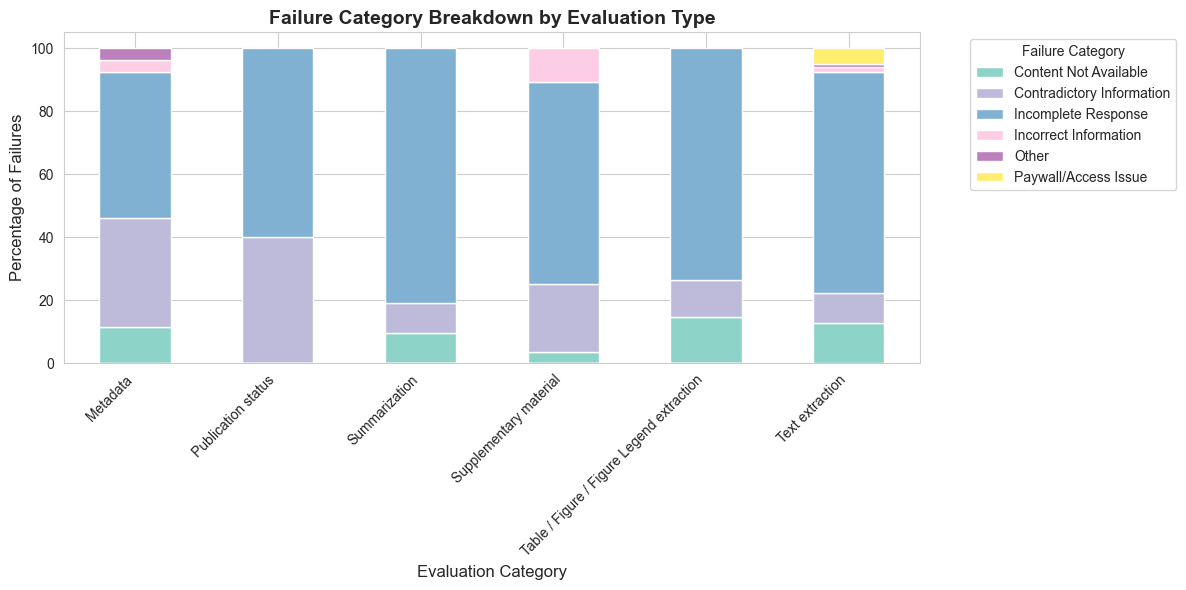

In [12]:
# Visualize failure categories by evaluation type
fig, ax = plt.subplots(figsize=(12, 6))

failure_breakdown.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
ax.set_title('Failure Category Breakdown by Evaluation Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Evaluation Category', fontsize=12)
ax.set_ylabel('Percentage of Failures', fontsize=12)
ax.legend(title='Failure Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../results/figures/failure_categories_by_eval_type.png', dpi=300, bbox_inches='tight')
plt.show()

## Agent-Specific Failure Patterns

In [13]:
# Failure categories by agent
agent_failure_breakdown = pd.crosstab(
    all_failures['agent'], 
    all_failures['failure_category'],
    normalize='index'
) * 100

print("Failure category breakdown by agent (% of failures):")
print(agent_failure_breakdown.round(1))

Failure category breakdown by agent (% of failures):
failure_category  Content Not Available  Contradictory Information  \
agent                                                                
claude                             13.8                       15.5   
gemini                              8.0                       13.8   
goose                              12.8                       15.1   

failure_category  Incomplete Response  Incorrect Information  Other  \
agent                                                                 
claude                           55.2                    5.2    0.0   
gemini                           74.7                    1.1    2.3   
goose                            69.8                    2.3    0.0   

failure_category  Paywall/Access Issue  
agent                                   
claude                            10.3  
gemini                             0.0  
goose                              0.0  


## MCP-Specific Failure Patterns

In [14]:
# Failure categories by MCP
mcp_failure_breakdown = pd.crosstab(
    all_failures['MCP'], 
    all_failures['failure_category'],
    normalize='index'
) * 100

print("Failure category breakdown by MCP (% of failures):")
print(mcp_failure_breakdown.round(1))

Failure category breakdown by MCP (% of failures):
failure_category  Content Not Available  Contradictory Information  \
MCP                                                                  
artl                                3.8                       19.2   
biomcp                              6.8                       11.9   
pubmed-mcp                         12.7                       11.1   
simple-pubmed                      21.1                       17.5   

failure_category  Incomplete Response  Incorrect Information  Other  \
MCP                                                                   
artl                             71.2                    1.9    0.0   
biomcp                           81.4                    0.0    0.0   
pubmed-mcp                       63.5                    6.3    3.2   
simple-pubmed                    56.1                    1.8    0.0   

failure_category  Paywall/Access Issue  
MCP                                     
artl               

## Summary Findings

Based on the analysis above, we can identify:
1. The most common failure modes across all categories
2. Category-specific failure patterns
3. Whether agents or MCPs show different failure characteristics

In [ ]:
# Identify potential FALSE NEGATIVES: Factually correct but failed due to verbosity/formatting
print("POTENTIAL FALSE NEGATIVES - Correct answers marked as failures")
print("="*100)

false_negatives = []

for idx, row in retraction_cases.iterrows():
    reason_lower = str(row['reason']).lower()
    
    # Check if evaluator says it's correct but it still failed
    if (not row['passed'] and 
        ('correctly states' in reason_lower or 
         ('does not contradict' in reason_lower and 'correct' in reason_lower) or
         'no factual contradictions' in reason_lower)):
        
        false_negatives.append(row)
        print(f"\n{row['case_name']} - {row['agent']} + {row['MCP']}")
        print(f"  Score: {row['score']:.3f} (FAILED but appears correct)")
        print(f"  Reason excerpt: {row['reason'][:300]}...")
        print("-"*100)

print(f"\n\n{'='*100}")
print(f"SUMMARY: {len(false_negatives)} potential false negatives out of {len(retraction_cases)} total retraction cases")
print(f"This represents {len(false_negatives)/len(retraction_cases)*100:.1f}% of retraction evaluations")
print(f"\nCurrent retraction pass rate: {retraction_cases['passed'].mean()*100:.1f}%")
print(f"If false negatives were corrected: {(retraction_cases['passed'].sum() + len(false_negatives))/len(retraction_cases)*100:.1f}%")

In [ ]:
# Detailed analysis of each retraction case
print("DETAILED RETRACTION CASE ANALYSIS")
print("="*100)

for i, (idx, row) in enumerate(retraction_cases.iterrows(), 1):
    print(f"\n{i}. {row['case_name']} - Agent: {row['agent']}, MCP: {row['MCP']}")
    print(f"   Score: {row['score']:.3f} | Passed: {row['passed']}")
    print(f"   Reason: {row['reason'][:400]}")
    
    # Check if the answer is factually correct based on the reason
    reason_lower = str(row['reason']).lower()
    output_lower = str(row['actual_output']).lower()
    
    # Look for indicators of correctness
    if 'correctly states' in reason_lower or 'correct' in reason_lower and 'not contradict' in reason_lower:
        factually_correct = "✓ FACTUALLY CORRECT"
    elif 'contradict' in reason_lower or 'incorrect' in reason_lower or 'wrong' in reason_lower:
        factually_correct = "✗ FACTUALLY WRONG"
    elif 'omit' in reason_lower or 'missing' in reason_lower or 'not provide' in reason_lower:
        factually_correct = "⚠ INCOMPLETE/MISSING"
    else:
        factually_correct = "? UNCLEAR"
    
    print(f"   Assessment: {factually_correct}")
    
    # Show first part of actual output
    print(f"   Output preview: {row['actual_output'][:200]}...")
    print("-"*100)

In [ ]:
# Get all retraction cases
retraction_cases = df_all[df_all['case_name'].str.contains('Retraction', case=False, na=False)].copy()

print(f"Total retraction evaluations: {len(retraction_cases)}")
print(f"Passed: {retraction_cases['passed'].sum()}")
print(f"Failed: {(~retraction_cases['passed']).sum()}")
print(f"Pass rate: {retraction_cases['passed'].mean()*100:.1f}%")
print(f"\nMean score: {retraction_cases['score'].mean():.3f}")
print(f"Score distribution:")
print(retraction_cases['score'].describe())

## CRITICAL: Retraction Eval Analysis - False Negatives from Verbosity?

Are we marking correct answers as failures just because agents provided extra detail?